# Global Temperature Trend

## Index

* [1. Imports](#imports-anchor)
* [2. Data Understanding](#data-anchor)
    * [2.1 Gather](#data-gather-anchor)
    * [2.2 Assessment](#data-exploration-anchor)
        * [2.2.1 GISTEMP](#gistemp-assess-anchor)
        * [2.2.2 AGGI](#aggi-assess-anchor)
        * [2.2.3 Gobal AOD](#aod-assess-anchor)
        * [2.2.4 ENSO](#enso-assess-anchor)
        * [2.2.5 TSI](#tsi-assess-anchor)
    * [2.3 Cleaning](#data-clean-anchor)
        * [2.3.1 GISTEMP](#gistemp-clean-anchor)
        * [2.3.2 AGGI](#aggi-clean-anchor)
        * [2.3.3 ENSO](#enso-clean-anchor)
        * [2.3.4 AOD Global](#aod-clean-anchor)
        * [2.3.5 ENSO](#enso-clean-anchor)
        * [2.3.6 TSI](#tsi-clean-anchor)
* [3 Analysis and Visualization](#data-analysis-anchor)
    * [3.1 GISTEMP](#gistemp-analysis-anchor)
    * [3.2 AGGI](#aggi-analysis-anchor)
    * [3.3 AOD Global](#aod-analysis-anchor)
    * [3.4 ENSO](#enso-analysis-anchor)
    * [3.5 TSI](#tsi-analysis-anchor)
    * [3.6 Historical global temperature anomaly trend](#gistemp-history-analysis-anchor)
    * [3.7 Comparing GISTEMP with other climate variables](#combine-analysis-anchor)
* [4. Model](#data-model-anchor)
* [5. Evaluation](#model-eval-anchor)
* [6. References and Resources](#ref-anchor)
* 7.Questions
    * Questions are intersepersed as they are asked and answered during the analysis
    * [Question 1](#q1-anchor)
        * [Answer 1](#a1-anchor)
    * [Question 2](#q2-anchor)
        * [Answer 2](#a2-anchor)
    * [Question 3](#q3-anchor)
        * [Answer 3](#a3-anchor)
    * [Question 4](#q4-anchor)
        * [Answer 4](#a4-anchor)
 

# 1. Imports <a class="anchor" id="imports-anchor"></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
from statsmodels.api import OLS

%matplotlib inline

# 2. Data Understanding <a class="anchor" id="data-anchor"></a>

## 2.1 Gather <a class="anchor" id="data-gather-anchor"></a>

In [2]:
aggi_table_df = pd.read_csv('AGGI_Table.csv')

In [3]:
gistemp_df = pd.read_csv('GLB.Ts+dSST.csv')

In [4]:
aod_global_df = pd.read_csv('aod_annual.csv')

In [5]:
enso_df = pd.read_csv('enso.csv')

In [6]:
tsi_df = pd.read_csv('composite_42_65_1709.txt', delim_whitespace=True, dtype = {'Date':'str', 'EpochDay': 'float', 
                                                                           'Avg_Irradiance_New': 'float', 
                                                                           'Avg_Irradiance_Old':'float'})

## 2.2 Assessment <a class="anchor" id="data-exploration-anchor"></a>

### 2.2.1 GISTEMP <a class="anchor" id="gistemp-assess-anchor"></a>

GISS Surface Temperature Analysis (GISTEMP) gives us an estimate of the global surface temperature change. It recalculates consistent temperature anomaly series from 1880 to the present. Temperature anomaly is the temperature deviation from the base period which in this case is average over the 30-year period from 1951 to 1980.

In [7]:
gistemp_df.shape

(141, 19)

In [8]:
gistemp_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.17,-0.24,-0.09,-0.16,-0.09,-0.2,-0.17,-0.09,-0.14,-0.23,-0.21,-0.17,-0.16,***,***,-0.11,-0.15,-0.19
1,1881,-0.19,-0.13,0.04,0.06,0.07,-0.18,0.01,-0.02,-0.14,-0.21,-0.18,-0.06,-0.08,-0.09,-0.16,0.05,-0.06,-0.18
2,1882,0.17,0.15,0.05,-0.16,-0.14,-0.22,-0.15,-0.06,-0.14,-0.23,-0.15,-0.35,-0.1,-0.08,0.09,-0.08,-0.14,-0.17
3,1883,-0.28,-0.36,-0.12,-0.17,-0.17,-0.07,-0.06,-0.13,-0.2,-0.1,-0.22,-0.1,-0.16,-0.19,-0.33,-0.15,-0.08,-0.18
4,1884,-0.12,-0.07,-0.35,-0.39,-0.34,-0.35,-0.31,-0.26,-0.26,-0.24,-0.32,-0.3,-0.28,-0.26,-0.1,-0.36,-0.31,-0.28


In [9]:
gistemp_df.tail(n = 1)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
140,2020,1.17,1.25,1.19,***,***,***,***,***,***,***,***,***,***,***,1.17,***,***,***


In [10]:
np.sum(gistemp_df.isna())

Year    0
Jan     0
Feb     0
Mar     0
Apr     0
May     0
Jun     0
Jul     0
Aug     0
Sep     0
Oct     0
Nov     0
Dec     0
J-D     0
D-N     0
DJF     0
MAM     0
JJA     0
SON     0
dtype: int64

### 2.2.2 AGGI <a class="anchor" id="aggi-assess-anchor"></a>

AGGI is a measure of the climate-warming influence of the long-lived greenhouse gases mainly: CO2, Methane, Nitrous Oxide, Chlorofluorocarbons, and other gases.
Let's review a few concepts before we start using this AGGI index in our model. 

Longwave and shortwave radiation: short wave radiation is given off by the Sun and contains more energy compared to the longwave radiation emitted by the Earth.

Going back to the eponymous greenhouse effect, the greenhouse gases allow the Sun's short wave radiation in, but absorbs the longwave radiation emitted by the Earth and reflects it back into the atmosphere and hence contribute to the warming. Greenhouse gases are necessary for life on earth but climatologists are concerned about the rising level due to anthropogenic activities. Especially because the rate at which global warming is happening is unprecedented.

<figure>
    <img src="greenhouse_effect_rev_5-22-19.gif" width = '50%'/>
    <center><figcaption>Credits: NASA-JPL/Caltech</figcaption></center>
</figure>

* [AGGI](https://www.esrl.noaa.gov/gmd/aggi/aggi.html) <br>
* [Graphic: The Greenhouse Effect](https://climate.nasa.gov/climate_resources/188/graphic-the-greenhouse-effect/)
* [Greenhouse effect](https://courses.edx.org/assets/courseware/v1/f40bce9bb2f3570cc65b5303558ab895/asset-v1:SDGAcademyX+CCSI001+3T2019+type@asset+block/Module_1_Reading_5.pdf)

In [11]:
aggi_table_df.shape

(40, 11)

In [12]:
aggi_table_df.head(n = 1)

,Year,CO2,CH4,N2O,CFC12,CFC11,15-minor,Total,Total.1,AGGI,AGGI % change *
0,1979,1.027,0.406,0.104,0.092,0.04,0.031,1.699,382,0.785,NaN


In [13]:
aggi_table_df.tail(n = 1)

,Year,CO2,CH4,N2O,CFC12,CFC11,15-minor,Total,Total.1,AGGI,AGGI % change *
39,2018,2.044,0.512,0.199,0.162,0.057,0.127,3.101,496,1.433,1.8


In [14]:
aggi_table_df.dtypes

Year                 int64
CO2                float64
CH4                float64
N2O                float64
CFC12              float64
CFC11              float64
15-minor           float64
Total              float64
Total.1              int64
AGGI               float64
AGGI % change *    float64
dtype: object

### 2.2.3 Gobal AOD <a class="anchor" id="aod-assess-anchor"></a>

Aerosols are any solid or liquid particles suspended in the air. For example, mineral dust, soot, black carbon, volcanic ash, etc. It is produced both naturally e.g sea spray or volcanic eruption, as well as due to human activities, like auto or industrial emission, smoking, and even cooking, and its presence affects us and the environment in numerous ways, such as causing various health hazards and changing both the global and local climate.
While the bulk of the aerosols are due to natural causes, we humans, are not relenting either in increasing more pollutants in the air.
Within the atmosphere, the aerosols in the Troposphere are largely due to vegetation, oceans, and deserts. The Aerosols in the stratosphere build up largely due to volcanic activities and can last a couple of years.
Here, we would specifically be looking at Stratospheric aerosols and how it relates to our investigation of global temperature anomaly over time.
Large explosive volcanoes inject sulfur dioxide into the stratosphere which reacts with the water vapors to form aerosols composed of sulfuric acid particles. This has a cooling effect on the Earth's surface but not all is good, as always the case with most things, these aerosols are detrimental to the stratospheric ozone.

* [Webinar on Atmospheric Aerosols by Dr. Yogesh Kant](https://www.youtube.com/watch?v=buFrS0NnVp4&list=PLq7KXmQCao4suRWH0r0DhNrUL_ecLGvZN&index=2&t=1976s)
* [Aerosols Factsheet - NASA](https://www.nasa.gov/centers/langley/news/factsheets/Aerosols.html)
* [Earth Observatory](https://earthobservatory.nasa.gov/features/Aerosols)
* [NASA's Earth Minute: My Name is Aerosol](https://www.youtube.com/watch?v=4eh6IKahbok)

In [15]:
aod_global_df.head()

,Year,Mean
0,1850,-0.431478
1,1851,-0.481065
2,1852,-0.530651
3,1853,-0.563709
4,1854,-0.605031


In [16]:
aod_global_df.tail()

,Year,Mean
165,2015,-0.605031
166,2016,-0.605031
167,2017,-0.605031
168,2018,-0.605031
169,2019,-0.605031


### 2.2.4 ENSO <a class="anchor" id="enso-assess-anchor"></a>

ENSO, the El Nino Southern Oscillation index, describes the linked phenomena of Southern Oscillation and El Nino. Southern Oscillation is the change in air pressure over the tropical Pacific Ocean whereas El Nino is the unusual pattern of warming of surface waters in the eastern tropical Pacific Ocean. When the coastal waters become warmer, the atmospheric pressure above the ocean decreases. Major phases of ENSO are El Nina, Neutral, and El Nino. It is a primary predictor of global climate disruptions.
We'll be talking about eastern and western regions of the tropics of the Pacific Ocean, and a review is in order, mainly that the eastern Pacific Ocean is actually in the Western Hemisphere, and the western Pacific Ocean, in the Eastern Hemisphere.
In a neutral or normal phase, strong winds blow from east to west over the tropical Pacific Ocean and in the process pushes the warm surface waters to the western Pacific and allow the cooler waters to rise up on the eastern coast such as for example on the coast of Peru or Ecuador. In this condition, the sea levels and the surface temperatures are higher in the western tropical region. E.g. higher in Indonesia compared to Ecuador and Peru.

<center>
<img src="ENSO_Normal.png" width = '50%'>
<font size = '1'> <b>Attribution:  <a href="//commons.wikimedia.org/wiki/User:Fred_the_Oyster" title="User:Fred the Oyster">Fred the Oyster</a> - <span class="int-own-work" lang="en">Own work</span>; derived from NOAA/PMEL/TAO diagrams (<a rel="nofollow" class="external text" href="https://web.archive.org/web/20131221182140/http://www.pmel.noaa.gov/tao/proj_over/diagrams/index.html">archived link</a>), Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=35205432">Link</a></b></font>

</center>

In the El Nino event, the trade wind weakens. It allows the warm water to move back towards the east and the thermocline, i.e. the level of ocean depth separating warm surface water from the colder water below, deepens. This prohibits upwelling i.e. rising of the cooler water to the surface, which in turn makes the water warmer and further weakens the trade winds. El Nino generally lasts for less than a year.

<center>
<img src = "ENSO_-_El_Niño.png"  width = '50%'>
<font size = '1'> <b>Attribution: <a href="//commons.wikimedia.org/wiki/User:Fred_the_Oyster" title="User:Fred the Oyster">Fred the Oyster</a> - <span class="int-own-work" lang="en">Own work</span>; derived from NOAA/PMEL/TAO diagrams (<a rel="nofollow" class="external text" href="https://web.archive.org/web/20131221182140/http://www.pmel.noaa.gov/tao/proj_over/diagrams/index.html">archived link</a>), Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=35205564">Link</a> </b></font>
</center>

La Nina, on the other hand, is the cooling of the tropical western Pacific Ocean. The trade winds blow even stronger, expanding the warm water pool in the western tropical side of the pacific ocean and cooling the eastern i.e the South American side. This causes the temperature difference between the two sides to increase further, causing more water evaporation, clouds, and rains in the tropical western pacific. El Nino can last between one to three years.
Here, I'm using MEI which is Multivariate ENSO Index that combines atmospheric and oceanic variables: Sea Level Pressure (SLP), Sea Surface Temperature (SST), a zonal and meridional component of the surface wind, and outgoing longwave radiation (OLR), over the tropical Pacific basin.

[climate.gov ENSO FAQ](https://www.climate.gov/news-features/understanding-climate/el-ni%C3%B1o-and-la-ni%C3%B1a-frequently-asked-questions)

[Billy Kessler](http://faculty.washington.edu/kessler/occasionally-asked-questions.html#q1)

[Understanding ENSO](https://www.youtube.com/watch?v=dzat16LMtQk)

[MEI](https://psl.noaa.gov/enso/mei/)

[Images from Wikipedia](https://en.wikipedia.org/wiki/El_Ni%C3%B1o)


In [17]:
enso_df.head(n=1)

,Year,ENSO
0,1979,0.255


In [18]:
enso_df.tail(n=1)

,Year,ENSO
41,2020,0.246667


### 2.2.5 TSI <a class="anchor" id="tsi-assess-anchor"></a>

Total Solar Irradiance (TSI) measures the amount of radiant energy emitted by the Sun over all the wavelengths each second on a 1 square meter perpendicular plane outside Earth's atmosphere.

Sun cyclically goes through dark and bright regions over eleven years period and although the primary source of energy on Earth, is not considered the main contributor to global warming.

In [19]:
tsi_df.head(n=1)

,Date,EpochDay,Avg_Irradiance_New,Avg_Irradiance_Old
0,781117,-408.5,1360.7259,1365.806


In [20]:
tsi_df.tail(n=1)

,Date,EpochDay,Avg_Irradiance_New,Avg_Irradiance_Old
14187,170920,13778.46,1360.5135,1365.5928


## 2.3 Cleaning <a class="anchor" id="data-clean-anchor"></a>

### 2.3.1 GISTEMP <a class="anchor" id="gistemp-clean-anchor"></a>

J stands for January, D for December. 
Header in the following page shows the use of the letters: https://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.txt

In [21]:
gistemp_df.rename(columns = {'J-D':'Global Temperature'}, inplace = True)

In [22]:
gistemp_df.head(n = 1)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Global Temperature,D-N,DJF,MAM,JJA,SON
0,1880,-0.17,-0.24,-0.09,-0.16,-0.09,-0.2,-0.17,-0.09,-0.14,-0.23,-0.21,-0.17,-0.16,***,***,-0.11,-0.15,-0.19


In [23]:
gistemp_df.tail(n = 1)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Global Temperature,D-N,DJF,MAM,JJA,SON
140,2020,1.17,1.25,1.19,***,***,***,***,***,***,***,***,***,***,***,1.17,***,***,***


Filtering for the annual mean global temperature

In [24]:
gistemp_df = gistemp_df.filter(['Year', 'Global Temperature'])

Removing the last year 2020 

In [25]:
gistemp_df = gistemp_df[:-1]

In [26]:
gistemp_df['Global Temperature'].dtype

dtype('O')

Casting the data type in the correct format

In [27]:
gistemp_df = gistemp_df.astype({'Global Temperature':'float'})

### 2.3.2 AGGI <a class="anchor" id="aggi-clean-anchor"></a>

* Dropping the column that will be not used.
* There are no nan columns.
* Setting year as in the index for this DataFrame

In [28]:
aggi_table_df.drop(columns = ['AGGI % change *'], inplace = True)

In [29]:
np.sum(aggi_table_df.isna())

Year        0
CO2         0
CH4         0
N2O         0
CFC12       0
CFC11       0
15-minor    0
Total       0
Total.1     0
AGGI        0
dtype: int64

In [30]:
aggi_table_df.set_index('Year', inplace = True)

### 2.3.4 AOD Global <a class="anchor" id="aod-clean-anchor"></a>

* There are no nan columns.
* Setting year as in the index for this DataFrame

In [31]:
np.sum(aod_global_df.isna())

Year    0
Mean    0
dtype: int64

In [32]:
aod_global_df.set_index('Year', inplace = True)

### 2.3.5 ENSO <a class="anchor" id="enso-clean-anchor"></a>

* There are no nan columns.
* Setting year as in the index for this DataFrame

In [33]:
np.sum(enso_df.isna())

Year    0
ENSO    0
dtype: int64

In [34]:
enso_df.set_index('Year', inplace = True)

### 2.3.6 TSI <a class="anchor" id="tsi-clean-anchor"></a>

* Date column is coded with year and month, since we are interested in annual mean, the year is extracted from date and irradiance meansure is aggregated.
* Setting year as in the index for this DataFrame

In [35]:
tsi_df['Year'] = tsi_df['Date'].str[:2] 

In [36]:
tsi_df['Year'].unique()

array(['78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99',
       '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17'], dtype=object)

In [37]:
tsi_df['Year'] = ["20"+x if int(x) <= 20 else "19"+x for x in tsi_df['Year']]

In [38]:
tsi_df['Year'].unique()

array(['1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985',
       '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [39]:
tsi_df['Year']

0        1978
1        1978
2        1978
3        1978
4        1978
         ... 
14183    2017
14184    2017
14185    2017
14186    2017
14187    2017
Name: Year, Length: 14188, dtype: object

In [40]:
tsi_df['Year'] = tsi_df['Year'].astype('int')

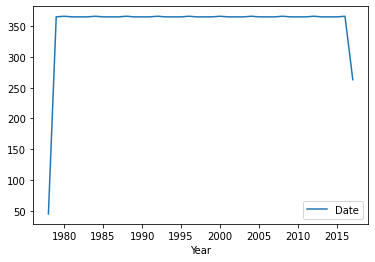

In [41]:
tsi_df.groupby('Year').agg({'Date':'count'}).plot()

**Graph above shows number of days in the year**

In [42]:
tsi_df.groupby('Year').agg({'Date':'count'}).head()

,Date
Year,
1978,45
1979,365
1980,366
1981,365
1982,365


In [43]:
tsi_df = tsi_df.groupby('Year').agg({'Avg_Irradiance_New':'mean'})

In [44]:
tsi_df.reset_index(inplace = True)

In [45]:
tsi_df.describe()

,Year,Avg_Irradiance_New
count,40.000000,40.000000
mean,1997.500000,1283.470076
std,11.690452,117.956123
min,1978.000000,949.412146
25%,1987.750000,1258.819676
50%,1997.500000,1341.024982
75%,2007.250000,1358.316079
max,2017.000000,1361.531203


**Because the year 1978 has data for only 45 days, we will drop that record**

In [46]:
tsi_df.drop(tsi_df.index[0], inplace = True)

In [47]:
tsi_df.set_index('Year', inplace = True)

In [48]:
tsi_df.head()

,Avg_Irradiance_New
Year,
1979,949.412146
1980,1221.883179
1981,997.470754
1982,989.208665
1983,1105.202704


## 3 Analysis and Visualization <a class="anchor" id="data-analysis-anchor"></a>

## 3.1 GISTEMP <a class="anchor" id="gistemp-analysis-anchor"></a>

In [49]:
gistemp_df['Moving Average Temperature'] = gistemp_df['Global Temperature'].rolling(10).mean()

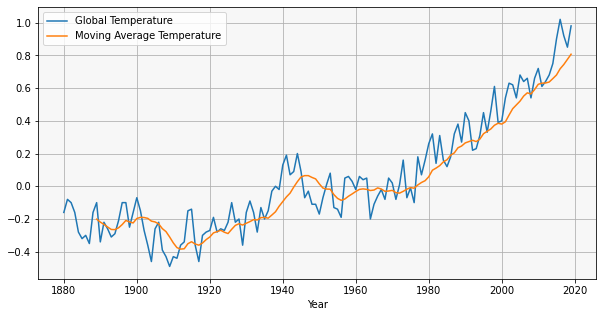

In [50]:
ax = gistemp_df.set_index('Year').plot(figsize = (10, 5))
ax.set_facecolor('#f7f7f7')
plt.grid(True)

**The graph above plots the global Global Temperature Anomaly and shows an upward trend**

## 3.2 AGGI <a class="anchor" id="aggi-analysis-anchor"></a>

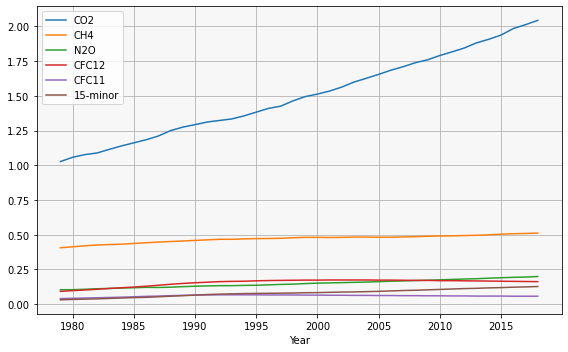

In [51]:
axs = aggi_table_df.plot(y = ['CO2', 'CH4', 'N2O', 'CFC12', 'CFC11', '15-minor'], figsize = (8, 5))
plt.grid(True)
axs.set_facecolor('#f7f7f7')
plt.tight_layout()

**AGGI is plotted on the y-axis below, and you can see that Carbon Dioxide is the largest contributor to the index followed by Methane**

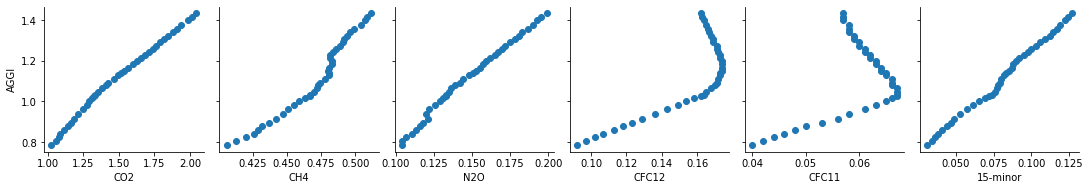

In [52]:
g = sns.PairGrid(aggi_table_df,
                 x_vars = ['CO2', 'CH4', 'N2O', 'CFC12', 'CFC11', '15-minor'],
                 y_vars = ['AGGI'])
g.map(plt.scatter)

**Pair-plot of major gases against the AGGI**

## 3.3 AOD Global <a class="anchor" id="aod-analysis-anchor"></a>

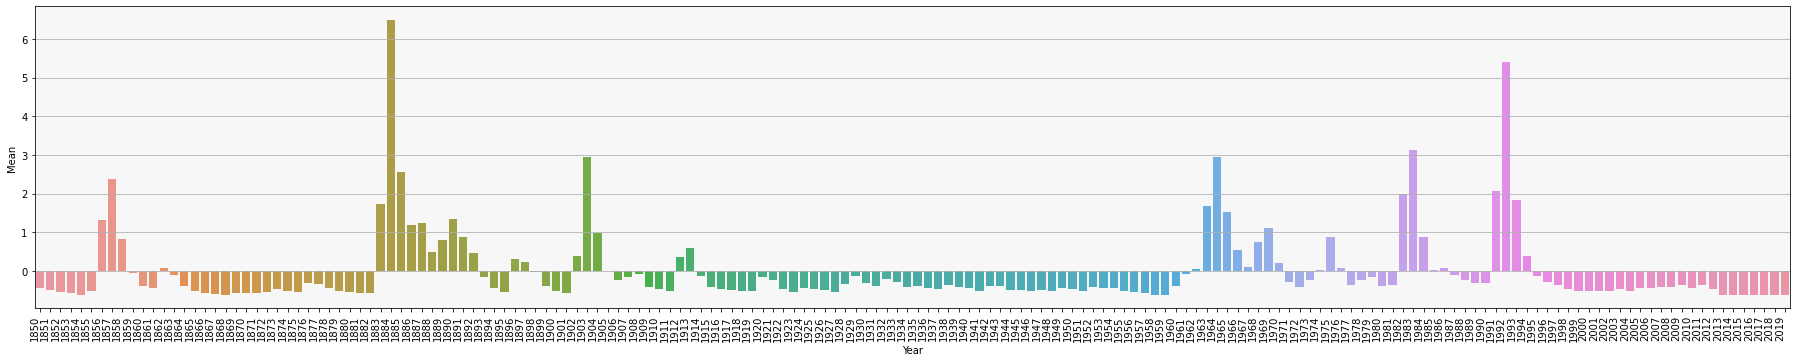

In [53]:
_,  axs = plt.subplots(figsize = (25, 5))

_ = axs.xaxis.set_ticks(np.arange(0, aod_global_df.shape[0], 1))
_ = axs.set_xticklabels(aod_global_df.index, rotation=90, ha="right")

axs.set_facecolor('#f7f7f7')
plt.grid(True)
plt.tight_layout()
sns.barplot(x = 'Year', y = 'Mean', data = aod_global_df.reset_index(), ax = axs)

**Above graph shows Stratospheric AOD timeseries**

Krakatau in 1883
https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_19th_century

Mount Pinatubo in 1991
https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_20th_century

## 3.4 ENSO <a class="anchor" id="enso-analysis-anchor"></a>

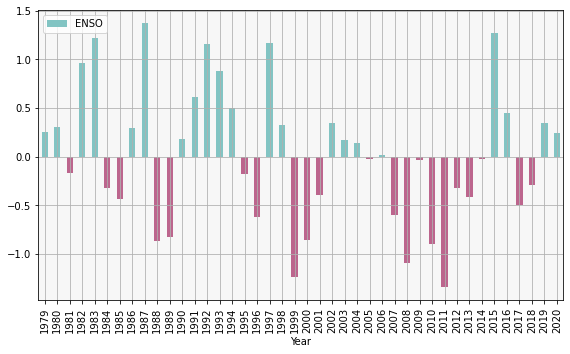

In [54]:
colormat=np.where(enso_df['ENSO']>0, '#82c4c3','#bc658d')
ax = enso_df.reset_index().plot(kind = 'bar', x = 'Year', y = 'ENSO', color = colormat, figsize = (8, 5))
ax.set_facecolor('#f7f7f7')
plt.grid(True)
plt.tight_layout(True)

**Graph above shows ENSO timeseries**

## 3.5 TSI <a class="anchor" id="tsi-analysis-anchor"></a>

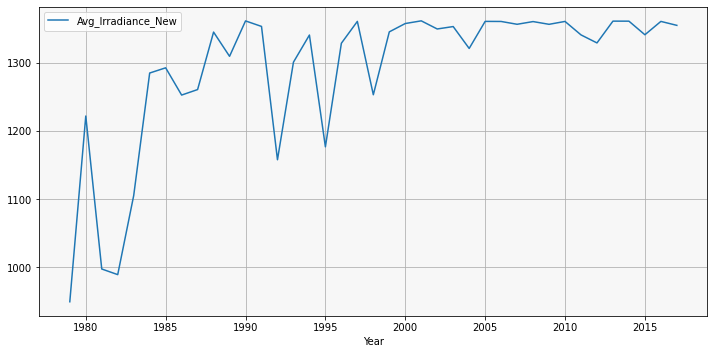

In [55]:
ax = tsi_df.plot(figsize = (10, 5))
ax.set_facecolor('#f7f7f7')
plt.grid(True)
plt.tight_layout(True)

**Graph above shows TSI timeseries**

## 3.6 Historical global temperature anamoly trend <a class="anchor" id="gistemp-history-analysis-anchor"></a>

<a class="anchor" id="q1-anchor"></a>
**Question 1:** What does the historical global anamoly trend signifies? How does a linear regression model fits?

In [56]:
def get_linear_model(df, x_cols, y_col):
    """Creates regression model, calculates r2 score, prediction output, explained variance and residuals.
     Keyword arguments:
     df -- data frame
     x_cols -- column names for input features
     y_col -- column name for output feature
    """

    X = df[x_cols]
    y = df[y_col]
    model = LinearRegression(normalize = True).fit(X, y)
    r2 = model.score(X, y)
    pred = model.predict(X)
    explained_variance = explained_variance_score(y, pred)
    residuals = y - pred
    return model, r2, residuals, pred, explained_variance

In [57]:
def plot_residuals(r, cols, fig_width, fig_height):
    """
    Utility function to plot the residuals.
    """

    _, axs = plt.subplots(1, cols, figsize = (fig_width, fig_height))
    if cols == 1:
        axs.scatter(x = r[0].index, y = r[0])
        axs.hlines(0, r[0].index.min(), r[0].index.max(), linestyles = 'dotted', colors = '#565d47')
        axs.set_facecolor('#f7f7f7')
    else:
        for i in range(0, len(r)):        
            axs[i].scatter(x = r[i].index, y = r[i])
            axs[i].set_facecolor('#f7f7f7')
            axs[i].hlines(0, r[i].index.min(), r[i].index.max(), linestyles = 'dotted', colors = '#565d47')
    
    plt.grid(True)
    plt.tight_layout(True)

In [58]:
m, r2, residuals, pred, ev = get_linear_model(gistemp_df, ['Year'], ['Global Temperature'])

In [59]:
display(f'Global Temperature = {m.coef_[0][0]:.4f} * Year + {m.intercept_[0]:.2f}')

'Global Temperature = 0.0074 * Year + -14.44'

In [60]:
ev

0.7461027051290179

'Explained Variance = 0.7461027051290179'

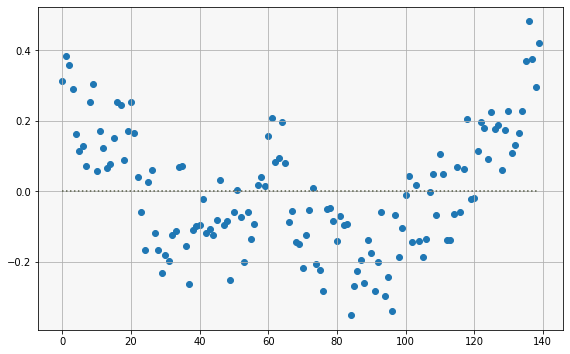

In [61]:
display(f'Explained Variance = {r2}')
plot_residuals([residuals], 1, 8, 5)

**Above graph shows residuals plot for the regression model**

<a class="anchor" id="a1-anchor"></a>
**Answer 1:** 

* [Timeseries graph for global temperature anamoly](#gistemp-analysis-anchor) shows an upward trend. 
* Fitting a linear regression model shows an average rate of increase of 0.0074 per year.
* But you can see above the residuals graph are not as random and has some shape like that of W which suggest there are other factors not included in the linear model affecting the linear model.

<a class="anchor" id="q2-anchor"></a>
**Question 2:** Can we improve the linear regression model?

We can try polynomial regression or other models but to complete the elementary treatment of this timeseries data and to better understand the change in temperature between different periods on the timeline. I decided to look for a possible division.

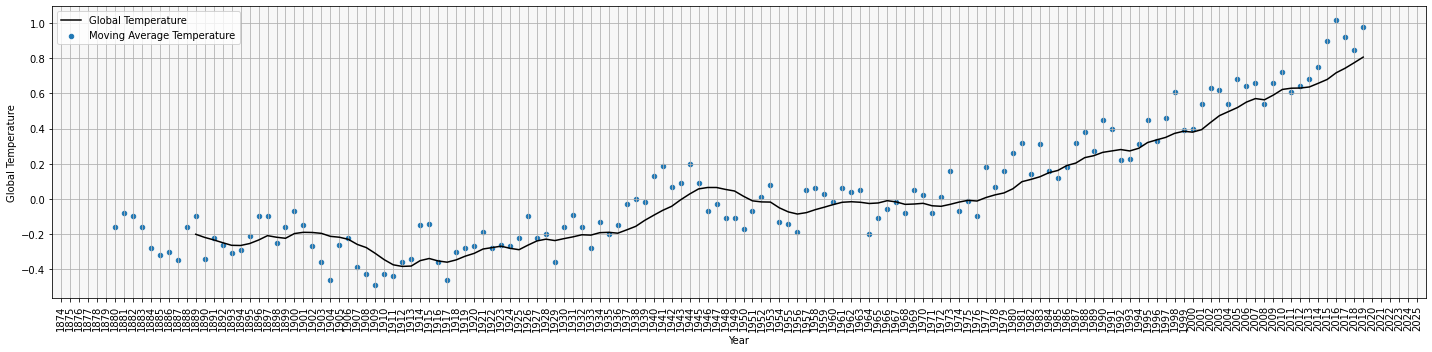

In [62]:
_, axs = plt.subplots(figsize = (20, 5))

gistemp_df.plot.scatter(x = 'Year', y = 'Global Temperature', ax = axs)
gistemp_df.plot(x = 'Year', y = 'Moving Average Temperature', color = 'black', ax = axs)

axs.set_facecolor('#f7f7f7')

axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
axs.legend(['Global Temperature', 'Moving Average Temperature'])
plt.xticks(rotation = 90)
plt.grid(True)
plt.tight_layout()

**More fine grained trend of annual global temperature and moving average**

Looking at the graph above, you can see the line before 1981 has more ups and downs. So we can go ahead and inspect the two time frames.

In [63]:
def divide_dataframe(df, conditional_column, condition):
    """
    Utility function to divide the dataframe's rows based on a condition.
    """

    A = df.loc[df[conditional_column] < condition]
    B = df.loc[df[conditional_column] >= condition]
    return A, B

In [64]:
Before_1981, After_1981 = divide_dataframe(gistemp_df.reset_index(), 'Year', 1981)

In [65]:
After_1981.head()

,index,Year,Global Temperature,Moving Average Temperature
101,101,1981,0.32,0.098
102,102,1982,0.14,0.111
103,103,1983,0.31,0.126
104,104,1984,0.16,0.149
105,105,1985,0.12,0.162


In [66]:
b_m, b_r2, b_residuals, b_pred, b_ev = get_linear_model(Before_1981, ['Year'], ['Global Temperature'])
a_m, a_r2, a_residuals, a_pred, a_ev = get_linear_model(After_1981, ['Year'], ['Global Temperature'])

Residuals graphs for divided time frame <a class="anchor" id="residual-divided-analysis-anchor"></a>

'Before 1981 Explained Variance = 0.4282, After 1981 Explained Variance = 0.848859'

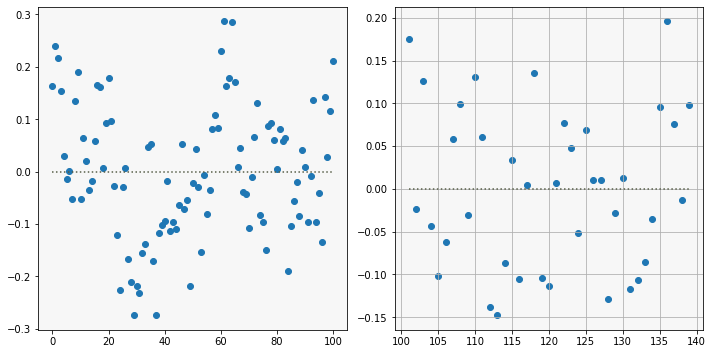

In [67]:
display(f'Before 1981 Explained Variance = {b_ev:.4f}, After 1981 Explained Variance = {a_ev:4f}')
plot_residuals([b_residuals, a_residuals], 2, 10, 5)

**Above graph shows residuals plot for the regression models before and after 1981**

In [68]:
avg_rate = a_m.coef_[0][0]
intercept = a_m.intercept_[0]
display(f'global_temperature = {avg_rate:0.4f}*x {intercept:4f}')
display(f'Average rate per decade {avg_rate*10:.4f}')

'global_temperature = 0.0194*x -38.320418'

'Average rate per decade 0.1942'

In [69]:
avg_rate = m.coef_[0][0]
intercept = m.intercept_[0]
display(f'global_temperature = {avg_rate:0.4f}*x {intercept:4f}')
display(f'Average rate per decade {avg_rate*10:.4f}')

'global_temperature = 0.0074*x -14.442634'

'Average rate per decade 0.0743'

In [70]:
avg_rate = b_m.coef_[0][0]
intercept = b_m.intercept_[0]
display(f'global_temperature = {avg_rate:0.4f}*x {intercept:4f}')
display(f'Average rate per decade {avg_rate*10:.4f}')

'global_temperature = 0.0037*x -7.340883'

'Average rate per decade 0.0373'

https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature

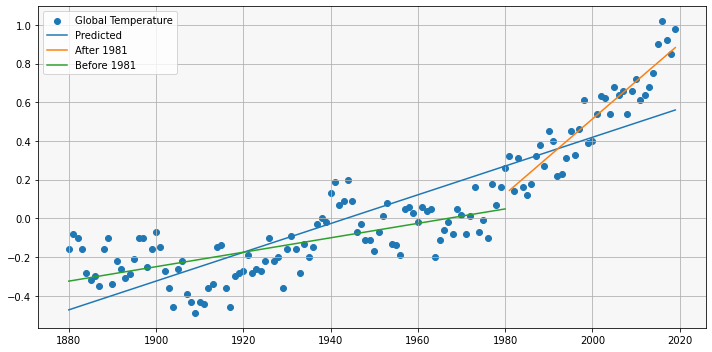

In [71]:
import matplotlib.lines as mlines

_, axs = plt.subplots(1,1, figsize = (10, 5))

gtemp = axs.scatter(x = gistemp_df['Year'], y = gistemp_df['Global Temperature'])
ptemp, = axs.plot(gistemp_df['Year'], pred)
a, = axs.plot(After_1981['Year'], a_pred)
b, = axs.plot(Before_1981['Year'], b_pred)

handles, labels = axs.get_legend_handles_labels()
handles = [gtemp, ptemp, a, b]
labels = ['Global Temperature', 'Predicted', 'After 1981', 'Before 1981']
axs.legend(handles, labels)
axs.set_facecolor('#f7f7f7')

plt.grid(True)
plt.tight_layout()

**Graph above shows the fitted line plotted against the global temperature trend**

<a class="anchor" id="a2-anchor"></a>
**Answer 2:** 
* After dividing the time frame into two timelines. We can see different rate of change per decade between the two time lines. The rate of change of the global temperature after 1981 is 0.1942 degrees centigrade per decade and 0.0743 degrees centigrade per decade since 1880.
* The explained variance increased and [residual plot](#residual-divided-analysis-anchor) improved for time frame after 1981.

In [72]:
gistemp_df.set_index('Year', inplace = True)

In [73]:
gistemp_df['Global Temperature'].index

Int64Index([1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
            ...
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='Year', length=140)

## 3.7 Comparing GISTEMP with other climate variables  <a class="anchor" id="combine-analysis-anchor"></a>

Combining all climate variables in one DataFrame

In [74]:
ind = gistemp_df.index
global_climate_df = pd.DataFrame({ 'GISTEMP': gistemp_df['Global Temperature'] 
                                  ,'AGGI': aggi_table_df.AGGI
                                  ,'TSI': tsi_df.Avg_Irradiance_New
                                  ,'ENSO': enso_df.ENSO
                                  ,'AOD_GLOBAL': aod_global_df.Mean
                                 }
                                 , index = ind)

In [75]:
global_climate_df.tail()

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
Year,,,,,
2015,0.90,1.374,1341.132354,1.276667,-0.605031
2016,1.02,1.399,1360.699306,0.452500,-0.605031
2017,0.92,1.415,1354.914150,-0.499167,-0.605031
2018,0.85,1.433,NaN,-0.288333,-0.605031
2019,0.98,NaN,NaN,0.344167,-0.605031


**Removing NaN rows**

The correlation methods from stats package cannot handle NaN's and imputing is not necessary as the missing values would be either at the beginning or at the end.

In [76]:
global_climate_df = global_climate_df.dropna()

In [77]:
global_climate_df.head()

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
Year,,,,,
1979,0.16,0.785,949.412146,0.255000,-0.146354
1980,0.26,0.807,1221.883179,0.306667,-0.377759
1981,0.32,0.825,997.470754,-0.167500,-0.365362
1982,0.14,0.840,989.208665,0.965833,1.998273
1983,0.31,0.859,1105.202704,1.219167,3.122240


In [78]:
def correlation_and_pvalue(df, correlation_method):
    """ Utility method to calculate correlation and pvalue """

    corr = np.zeros((5,5))
    pvalues = np.zeros((5,5))

    feature_names = df.columns.values
    feature_size = len(feature_names)
    
    for row in range(0, feature_size):
        for col in range(0, feature_size):
            c = 0
            p = 0
            if correlation_method == 'pearson':
                c, p = stats.pearsonr(df[feature_names[row]], df[feature_names[col]])
            elif correlation_method == 'spearman':
                c, p = stats.spearmanr(df[feature_names[row]], df[feature_names[col]])
            elif correlation_method == 'kendall':
                c, p = stats.kendalltau(df[feature_names[row]], df[feature_names[col]])
                
            corr[row][col] = c
            pvalues[row][col] = p

    corr_df = pd.DataFrame(corr, index = feature_names, columns = feature_names)
    pvalues_df = pd.DataFrame(pvalues, index = feature_names, columns = feature_names)
    
    return corr_df, pvalues_df

corrs_pval = [None]*6
corrs_pval[0], corrs_pval[1] = correlation_and_pvalue(global_climate_df, 'pearson')
corrs_pval[2], corrs_pval[3] = correlation_and_pvalue(global_climate_df, 'spearman')
corrs_pval[4], corrs_pval[5] = correlation_and_pvalue(global_climate_df, 'kendall')

**Scaling feature set**

In [79]:
scaled = StandardScaler().fit_transform(global_climate_df.values)

In [80]:
from sklearn.preprocessing import normalize
n = normalize(scaled)

In [81]:
#global_climate_df = pd.DataFrame(scaled, index = global_climate_df.index, columns = global_climate_df.columns)
global_climate_df = pd.DataFrame(scaled, index = global_climate_df.index, columns = global_climate_df.columns)

In [82]:
global_climate_df.describe()

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
count,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01
mean,-1.252559e-16,-1.594166e-16,-6.205862e-16,-1.423363e-17,6.262797e-17
std,1.013072e+00,1.013072e+00,1.013072e+00,1.013072e+00,1.013072e+00
min,-1.577707e+00,-1.797704e+00,-3.133027e+00,-1.888626e+00,-5.739116e-01
25%,-7.390548e-01,-7.431379e-01,-1.632913e-01,-6.690989e-01,-4.763431e-01
50%,-1.211009e-01,2.610773e-02,4.636797e-01,-4.829102e-02,-3.787746e-01
75%,7.175509e-01,8.149342e-01,6.280136e-01,5.399651e-01,-1.630969e-01
max,2.394855e+00,1.726840e+00,6.509784e-01,1.896675e+00,4.400368e+00


In [83]:
color_mapping = {'GISTEMP':'#f0134d', 
                 'ENSO' : '#222831',
                 'AOD_GLOBAL': '#06623b',
                 'TSI': '#ff5200',
                 'AGGI': '#95389e',
                 'FACE_COLOR': '#f7f7f7'}

legend_mapping = {'GISTEMP': 'Global Temperature Anomaly',
                  'ENSO': 'ENSO',
                  'AOD_GLOBAL': 'Stratospheric AOD',
                  'TSI' : 'Total Solar Irradiance',
                  'AGGI': 'Annual Greenhouse Gas Index'
                 }

In [84]:
def graph_temperature_vs_forcers(forcers, enso_bar = False):
    """
    Utility function to visualize climate variables with temperature.
    """
    
    fig, axs = plt.subplots(figsize = (10, 5))
    global_climate_df['GISTEMP'].plot(ax = axs, color = color_mapping['GISTEMP'])
    legend_labels = [legend_mapping['GISTEMP']]
    
    for f in forcers:
        global_climate_df[f].plot(ax = axs, color = color_mapping[f])
        legend_labels.append(legend_mapping[f])
    
    if enso_bar:
        colormat=np.where(global_climate_df['ENSO']>0, '#82c4c3','#bc658d')
        axs.bar(global_climate_df.index.values, global_climate_df['ENSO'], color = colormat)
        legend_labels.append('ENSO Bar')
    
    axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xticks(rotation=90)
    axs.legend(legend_labels)
    
    axs.set_facecolor(color_mapping['FACE_COLOR'])
    plt.grid(True)
    plt.tight_layout()
    

**GISTEMP vs ENSO**

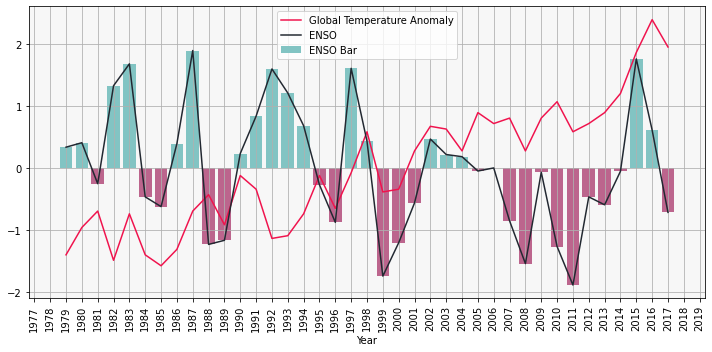

In [85]:
graph_temperature_vs_forcers(['ENSO'], True)

**Above graph compares ENSO with Global Temperature**

**GISTEMP vs AOD**

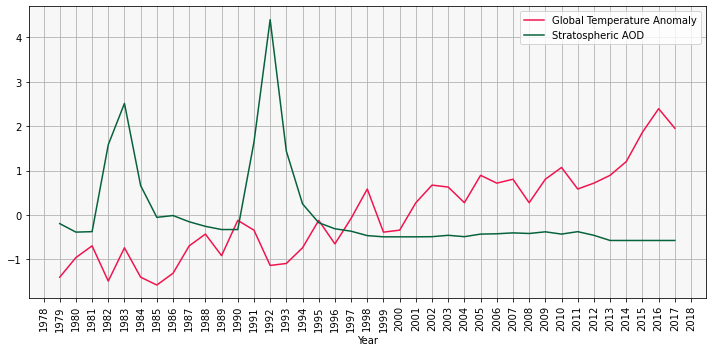

In [86]:
graph_temperature_vs_forcers(['AOD_GLOBAL'])

**Above graph compares Stratospheric AOD with Global Temperature**

**GISTEMP vs ENSO and AOD**

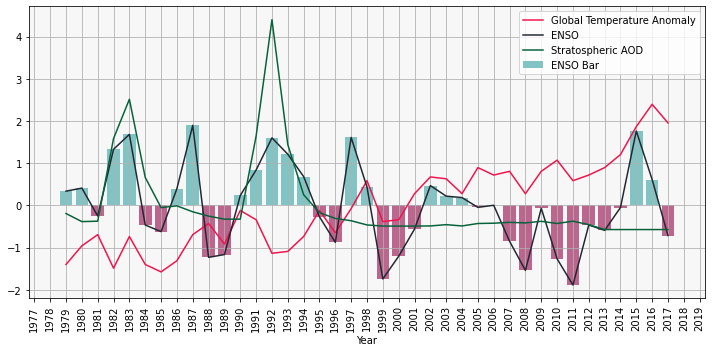

In [87]:
graph_temperature_vs_forcers(['ENSO', 'AOD_GLOBAL'], True)

**Above graph compares Stratospheric AOD, GISTEMP, and ENSO with Global Temperature**

**GISTEMP vs ENSO, AOD, and TSI**

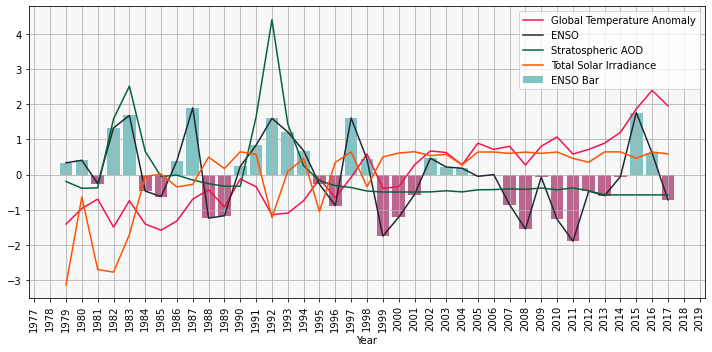

In [125]:
graph_temperature_vs_forcers(['ENSO','AOD_GLOBAL', 'TSI'], True)

**Above graph compares Stratospheric AOD, TSI, and ENSO with Global Temperature**

**GISTEMP vs ENSO, AOD, AGGI and TSI**

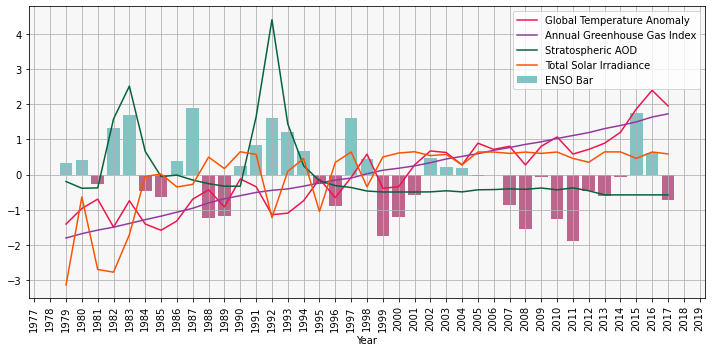

In [127]:
graph_temperature_vs_forcers(['AGGI', 'AOD_GLOBAL', 'TSI'], True)

**Above graph compares Stratospheric AOD, ENSO, AGGI, and TSI with Global Temperature**

**GISTEMP vs TSI**

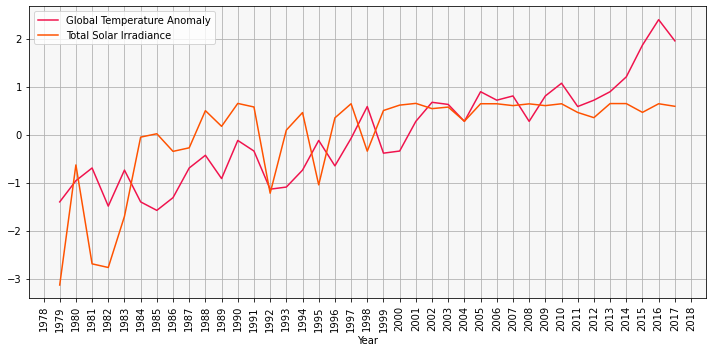

In [90]:
graph_temperature_vs_forcers(['TSI'], False)

**Above graph compares TSI with Global Temperature**

In [91]:
global_climate_df.shape

(39, 5)

**Pair plots between GISTEMP and other variables**

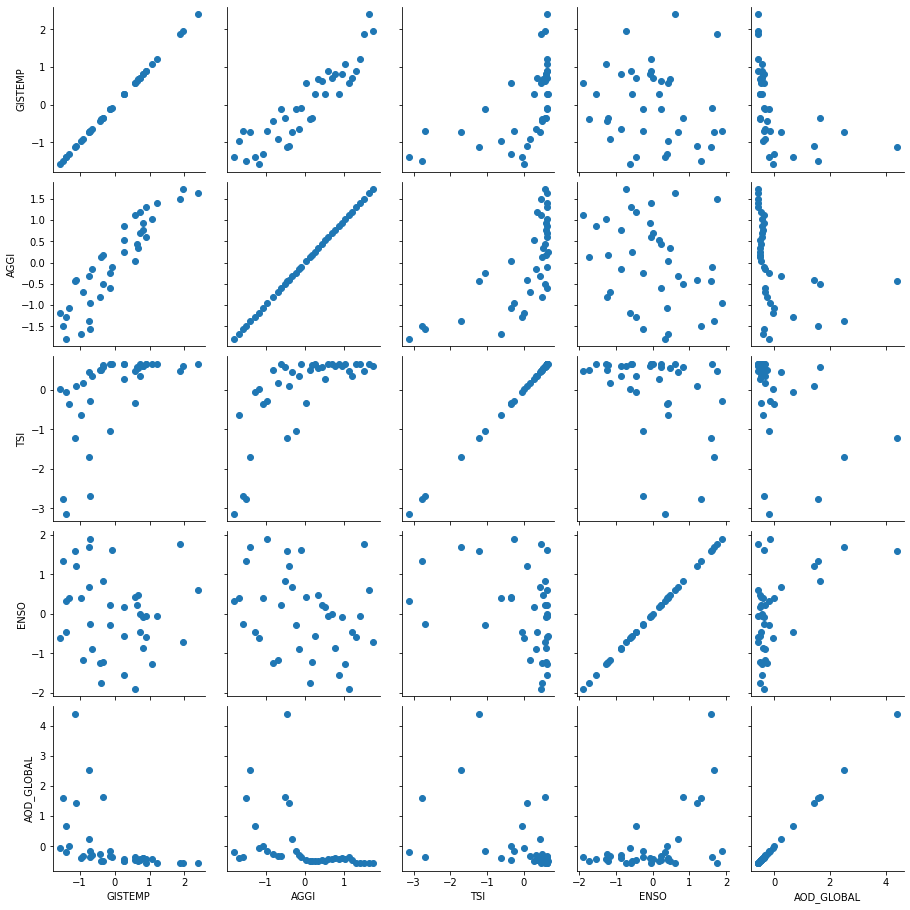

In [92]:
g = sns.PairGrid(global_climate_df)
g.map(plt.scatter)

**Pair plots visualizing relationship with all variables**

In [93]:
global_climate_df.tail(n = 1)

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
Year,,,,,
2017,1.953459,1.72684,0.590222,-0.715601,-0.573912


<a class="anchor" id="q3-anchor"></a>
**Question 3:** What is the relationship between the climate variables?

We can use different correlation methods and p-values to asses the relationship between the variables and specifically with GISTEMP

In [94]:
global_climate_df.corr()

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
GISTEMP,1.000000,0.910696,0.558380,-0.142327,-0.478559
AGGI,0.910696,1.000000,0.687387,-0.280750,-0.405223
TSI,0.558380,0.687387,1.000000,-0.340251,-0.423336
ENSO,-0.142327,-0.280750,-0.340251,1.000000,0.495794
AOD_GLOBAL,-0.478559,-0.405223,-0.423336,0.495794,1.000000


In [95]:
corrs_pval = [None]*6
corrs_pval[0], corrs_pval[1] = correlation_and_pvalue(global_climate_df, 'pearson')
corrs_pval[2], corrs_pval[3] = correlation_and_pvalue(global_climate_df, 'spearman')
corrs_pval[4], corrs_pval[5] = correlation_and_pvalue(global_climate_df, 'kendall')

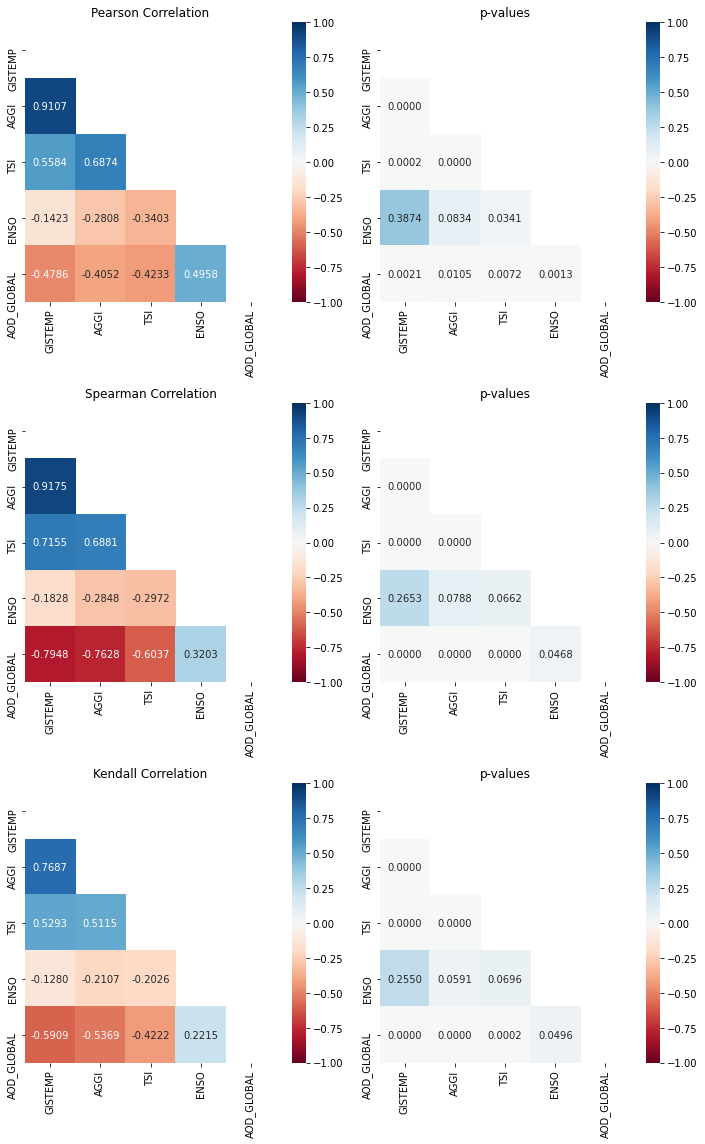

In [96]:
_, axs = plt.subplots(3,2, figsize = (10, 16))
axs = axs.flatten()

mask = np.zeros(corrs_pval[0].shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
titles = ['Pearson Correlation', 'p-values', 'Spearman Correlation', 'p-values', 
          'Kendall Correlation', 'p-values']

for i in range(0, 6):
    axs[i].set_title(titles[i])
    sns.heatmap(corrs_pval[i], annot = True,
                vmin = -1, vmax = 1, center = 0,
                cmap = 'RdBu', ax = axs[i], 
                mask = mask,
                fmt = '.4f')

plt.tight_layout()

**The graph aboves displays correlations between the variables using various correlation methods**

In [128]:
stats.pearsonr(global_climate_df['AOD_GLOBAL'].values, global_climate_df['AGGI'].values)

(-0.4052233237924801, 0.01049390332585624)

In [129]:
stats.spearmanr(global_climate_df['AOD_GLOBAL'].values, global_climate_df['AGGI'].values)

SpearmanrResult(correlation=-0.762759933894638, pvalue=1.6610663267954523e-08)

In [130]:
global_climate_df.shape

(39, 5)

<a class="anchor" id="a3-anchor"></a>
**Answer 3:**
* All three methods are showing global temperature to be positively correlated with the greenhouse gas index
* And negatively correlated with Stratospheric Aerosols.
* The p-value for all the methods between these two variables is lower than 0.05 and based on that I would infer that AOD is moderate to highly correlated with GISTEMP.
* I’m not exactly sure why there is a correlation between AOD and AGGI.

## 4. Model <a class="anchor" id="data-model-anchor"></a>

<a class="anchor" id="q4-anchor"></a>
**Question 4:**
Can we create a regression model considering all the climate variables introduced above?

We can use multivariable regression model to fit this data.

**Partition for output feature and explanatory features**

In [132]:
X = global_climate_df[['AGGI', 'ENSO', 'TSI', 'AOD_GLOBAL']]

In [131]:
y = global_climate_df[['GISTEMP']]

**Find the combination of features with highest adjusted explained variance**

In [102]:
import itertools

In [103]:
all_combs = [
             ['AGGI', 'AOD_GLOBAL'],
             ['AGGI','ENSO'],
             ['AGGI', 'TSI'],
             ['AOD_GLOBAL', 'ENSO'],
             ['AOD_GLOBAL', 'TSI'],
             ['ENSO', 'TSI'],
             ['AGGI', 'ENSO', 'AOD_GLOBAL'],
             ['AGGI', 'ENSO', 'AOD_GLOBAL', 'TSI']
            ]

for c in all_combs:
    x = global_climate_df[c]
    ols = OLS(y, x).fit()
    display(f'== FEATURES = {c}, R2 = {ols.rsquared},  Adjusted R2 = {ols.rsquared_adj} == ')    

"== FEATURES = ['AGGI', 'AOD_GLOBAL'], R2 = 0.8437190042891626,  Adjusted R2 = 0.8352713828993876 == "

"== FEATURES = ['AGGI', 'ENSO'], R2 = 0.8433144021478371,  Adjusted R2 = 0.8348449103720446 == "

"== FEATURES = ['AGGI', 'TSI'], R2 = 0.8380350423951359,  Adjusted R2 = 0.8292801798219 == "

"== FEATURES = ['AOD_GLOBAL', 'ENSO'], R2 = 0.24097030885836135,  Adjusted R2 = 0.1999416769047594 == "

"== FEATURES = ['AOD_GLOBAL', 'TSI'], R2 = 0.383244000470628,  Adjusted R2 = 0.3499058383339053 == "

"== FEATURES = ['ENSO', 'TSI'], R2 = 0.31435762988087745,  Adjusted R2 = 0.27729588014470874 == "

"== FEATURES = ['AGGI', 'ENSO', 'AOD_GLOBAL'], R2 = 0.8794877045704925,  Adjusted R2 = 0.8694450132847003 == "

"== FEATURES = ['AGGI', 'ENSO', 'AOD_GLOBAL', 'TSI'], R2 = 0.8890898741981644,  Adjusted R2 = 0.8764144312493832 == "

**Looking at V.I.F to check for collinearity**

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Xc = add_constant(X)
pd.Series([variance_inflation_factor(Xc.values, i) 
           for i in range(Xc.shape[1])], 
          index=Xc.columns)

const         1.000000
AGGI          1.954668
ENSO          1.363374
TSI           2.025896
AOD_GLOBAL    1.507263
dtype: float64

**Create LinearRegression model**

After looking at the adjusted R2 from the OLS summary of all the combinations, I'm going to drop TSI. Adjusted R2 with TSI is not much different from the model without it.

In [137]:
X = global_climate_df[['AGGI', 'ENSO', 'AOD_GLOBAL']]

In [138]:
# data already standardized
model = LinearRegression(normalize = False).fit(X, y)

In [139]:
model.coef_

array([[ 0.87850448,  0.21888647, -0.23109146]])

In [140]:
model.intercept_

array([9.8143876e-17])

In [141]:
display(f'Global Temperature = {model.coef_[0][0]:.2f} * AGGI + {model.coef_[0][1]:.2f} * ENSO {model.coef_[0][2]:.2f} * AOD {model.intercept_[0]:0.2e}')

'Global Temperature = 0.88 * AGGI + 0.22 * ENSO -0.23 * AOD 9.81e-17'

In [142]:
res = y - model.predict(X)

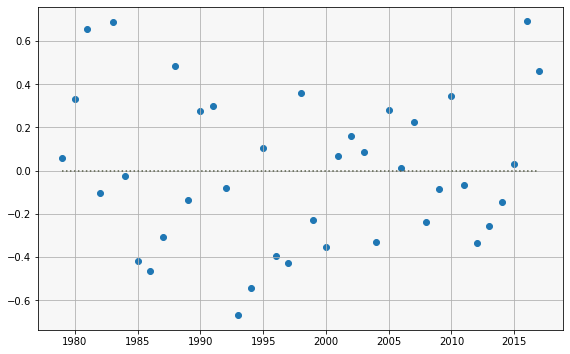

In [143]:
plot_residuals([res], 1, 8, 5)

In [144]:
res_standard = pd.DataFrame(StandardScaler().fit_transform(res))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb08525410>]],
      dtype=object)

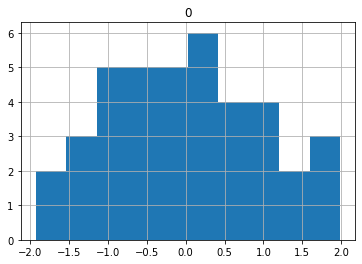

In [145]:
res_standard.hist()

<a class="anchor" id="a4-anchor"></a>
**Answer 4:**

As expected, we have a large coefficient value for AGGI, negative for AOD as it cools the atmosphere, and the rest of the coefficients are contributing positively to the global temperature.

The next section below prints the metrics for evaluation.

## 5. Evaluation <a class="anchor" id="model-eval-anchor"></a>

In [146]:
r2 = model.score(X,y)

In [147]:
display(f'R2 = {r2:.3f}')

'R2 = 0.879'

In [148]:
adj_rsquared = 1-(1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

In [149]:
adj_rsquared
display(f'Adjusted R2 = {adj_rsquared:.3f}')

'Adjusted R2 = 0.869'

In [150]:
pred = model.predict(X)

In [151]:
explained_variance = explained_variance_score(y, pred)
explained_variance

0.8794877045704925

In [152]:
global_climate_df.describe()

,GISTEMP,AGGI,TSI,ENSO,AOD_GLOBAL
count,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01
mean,-1.252559e-16,-1.594166e-16,-6.205862e-16,-1.423363e-17,6.262797e-17
std,1.013072e+00,1.013072e+00,1.013072e+00,1.013072e+00,1.013072e+00
min,-1.577707e+00,-1.797704e+00,-3.133027e+00,-1.888626e+00,-5.739116e-01
25%,-7.390548e-01,-7.431379e-01,-1.632913e-01,-6.690989e-01,-4.763431e-01
50%,-1.211009e-01,2.610773e-02,4.636797e-01,-4.829102e-02,-3.787746e-01
75%,7.175509e-01,8.149342e-01,6.280136e-01,5.399651e-01,-1.630969e-01
max,2.394855e+00,1.726840e+00,6.509784e-01,1.896675e+00,4.400368e+00


**Display statistical model using OLS**

In [153]:
ols = OLS(y, X).fit()

In [154]:
ols.rsquared_adj

0.8694450132847003

In [155]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                GISTEMP   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              87.57
Date:                Tue, 26 May 2020   Prob (F-statistic):                    1.32e-16
Time:                        15:54:48   Log-Likelihood:                         -14.077
No. Observations:                  39   AIC:                                      34.15
Df Residuals:                      36   BIC:                                      39.14
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGGI           0.8785      0.064     13.811      0.000       0.749       1.008
ENSO           0.2189      0.067      3.269      0.002       0.083       0.355
AOD_GLOBAL    -0.2311      0.070     -3.287      0.002      -0.374      -0.089
==============================================================================
Omnibus:                        1.465   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.213
Skew:                           0.237   Prob(JB):                        0.545
Kurtosis:                       2.278   Cond. No.                         1.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6. References and Resources <a class="anchor" id="ref-anchor"></a>

- GISTEMP
    - https://data.giss.nasa.gov/gistemp/ 
    - Date of access: 5th May 2020
    - GISTEMP Team, 2020: GISS Surface Temperature Analysis (GISTEMP), version 4. NASA Goddard Institute for Space Studies. Dataset accessed 20YY-MM-DD at https://data.giss.nasa.gov/gistemp/.

  - Lenssen, N., G. Schmidt, J. Hansen, M. Menne, A. Persin, R. Ruedy, and D. Zyss, 2019: Improvements in the GISTEMP uncertainty model. J. Geophys. Res. Atmos., 124, no. 12, 6307-6326, doi:10.1029/2018JD029522.

- https://psl.noaa.gov/data/climateindices/

- https://climexp.knmi.nl/daily2longer.cgi

- TSI
  - ftp://ftp.pmodwrc.ch/pub/data/irradiance/composite/
  - https://www.pmodwrc.ch/en/home/

- ENSO
    - [Climate Indices](https://psl.noaa.gov/cgi-bin/data/climateindices/corr.pl?tstype1=27&custname1=&custtitle1=&tstype2=0&custname2=&custtitle2=&year1=&year2=&itypea=0&y1=&y2=&plotstyle=0&length=&lag=&iall=0&iseas=1&mon1=0&mon2=11&anom=1&climo1_yr1=&climo1_yr2=&climo2_yr1=&climo2_yr2=&Submit=Calculate+Results)
  
- Aerosols
    - https://data.giss.nasa.gov/modelforce/strataer/
- Interpreting Correations
    - https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8
   